In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import random
import copy
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import pickle

# Dataset Import

In [2]:
base_path = r'C:\Users\RACYM\Desktop\fac\M2_PFE\datasets\CIC-DDoS2019\\'

cic_ddos2019 = {
    'DNS-test': pd.read_parquet(base_path + 'DNS-testing.parquet', engine='fastparquet'),
    'LDAP-test': pd.read_parquet(base_path + 'LDAP-testing.parquet', engine='fastparquet'),
    'LDAP-train': pd.read_parquet(base_path + 'LDAP-training.parquet', engine='fastparquet'),
    'MSSQL-test': pd.read_parquet(base_path + 'MSSQL-testing.parquet', engine='fastparquet'),
    'MSSQL-train': pd.read_parquet(base_path + 'MSSQL-training.parquet', engine='fastparquet'),
    'NetBIOS-test': pd.read_parquet(base_path + 'NetBIOS-testing.parquet', engine='fastparquet'),
    'NetBIOS-train': pd.read_parquet(base_path + 'NetBIOS-training.parquet', engine='fastparquet'),
    'NTP-test': pd.read_parquet(base_path + 'NTP-testing.parquet', engine='fastparquet'),
    'Portmap-train': pd.read_parquet(base_path + 'Portmap-training.parquet', engine='fastparquet'),
    'SNMP-test': pd.read_parquet(base_path + 'SNMP-testing.parquet', engine='fastparquet'),
    'Syn-test': pd.read_parquet(base_path + 'Syn-testing.parquet', engine='fastparquet'),
    'Syn-train': pd.read_parquet(base_path + 'Syn-training.parquet', engine='fastparquet'),
    'TFTP-test': pd.read_parquet(base_path + 'TFTP-testing.parquet', engine='fastparquet'),
    'UDPLag-test': pd.read_parquet(base_path + 'UDPLag-testing.parquet', engine='fastparquet'),
    'UDPLag-train': pd.read_parquet(base_path + 'UDPLag-training.parquet', engine='fastparquet'),
    'UDP-test': pd.read_parquet(base_path + 'UDP-testing.parquet', engine='fastparquet'),
    'UDP-train': pd.read_parquet(base_path + 'UDP-training.parquet', engine='fastparquet'),
}

# merging between train sets and test sets for each attack type
cic_ddos2019_merged = {
    'DNS': cic_ddos2019['DNS-test'],
    'LDAP': pd.concat([cic_ddos2019['LDAP-train'], cic_ddos2019['LDAP-test']], ignore_index=True),
    'MSSQL': pd.concat([cic_ddos2019['MSSQL-train'], cic_ddos2019['MSSQL-test']], ignore_index=True),
    'NetBIOS': pd.concat([cic_ddos2019['NetBIOS-train'], cic_ddos2019['NetBIOS-test']], ignore_index=True),    
    'NTP': cic_ddos2019['NTP-test'],
    'Portmap': cic_ddos2019['Portmap-train'],
    'SNMP': cic_ddos2019['SNMP-test'],
    'Syn': pd.concat([cic_ddos2019['Syn-train'], cic_ddos2019['Syn-test']], ignore_index=True),
    'TFTP': cic_ddos2019['TFTP-test'],
    'UDPLag': pd.concat([cic_ddos2019['UDPLag-train'], cic_ddos2019['UDPLag-test']], ignore_index=True),
    'UDP': pd.concat([cic_ddos2019['UDP-train'], cic_ddos2019['UDP-test']], ignore_index=True),
}

# merging all attack types 
cic_ddos2019_all = pd.concat(cic_ddos2019_merged.values(), ignore_index=True)

In [3]:
# maxSamples = 5000
# balancedParts = []
# for label, group in cic_ddos2019_all.groupby('Label'):
#     if maxSamples <= len(group):
#         sampled_DF = group.sample(n=maxSamples)
#     else:
#         sampled_DF = group
#     balancedParts.append(sampled_DF)
# cic_ddos2019_all = pd.concat(balancedParts, ignore_index=True)

# print(cic_ddos2019_all.shape)

# Data Preprocessing

In [4]:
# dropping constant features
cic_ddos2019_all.drop(['Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'FIN Flag Count',
 'PSH Flag Count',
 'ECE Flag Count',
 'Fwd Avg Bytes/Bulk',
 'Fwd Avg Packets/Bulk',
 'Fwd Avg Bulk Rate',
 'Bwd Avg Bytes/Bulk',
 'Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate'], axis=1, inplace=True)

# dropping columns highly correlated with other columns
cic_ddos2019_all.drop(['Bwd Packets Length Total',
                                'Fwd Packet Length Mean',
                                'Bwd Packet Length Std', 'Flow IAT Std', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
                                'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Packets/s', 'Packet Length Min', 'Packet Length Mean', 'Packet Length Std',
                                'RST Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets',
                                'Subflow Bwd Bytes', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min'], axis=1, inplace=True)

# Outlier treatement
labels = cic_ddos2019_all['Label']
cic_ddos2019_all = (cic_ddos2019_all.iloc[:,:-1] - cic_ddos2019_all.iloc[:,:-1].mean()) / cic_ddos2019_all.iloc[:,:-1].std()
cic_ddos2019_all['Protocol'], _ = pd.factorize(cic_ddos2019_all['Protocol'])
cic_ddos2019_all['Flow Duration'] = np.log1p(cic_ddos2019_all['Flow Duration']).clip(upper=0)
cic_ddos2019_all['Total Fwd Packets'] = np.log1p(cic_ddos2019_all['Total Fwd Packets']).clip(upper=0.2)
cic_ddos2019_all['Total Backward Packets'] = np.log1p(cic_ddos2019_all['Total Backward Packets']).clip(upper=0.2)
cic_ddos2019_all['Fwd Packets Length Total'] = np.log1p(cic_ddos2019_all['Fwd Packets Length Total']).clip(upper=0.5)
cic_ddos2019_all['Fwd Packet Length Max'] = np.log1p(cic_ddos2019_all['Fwd Packet Length Max'].clip(lower=0)).clip(upper=1.25)

cic_ddos2019_all['Fwd Packet Length Min'] = np.log1p(cic_ddos2019_all['Fwd Packet Length Min'].clip(lower=0)).clip(upper=2)
cic_ddos2019_all['Fwd Packet Length Std'] = np.log1p(cic_ddos2019_all['Fwd Packet Length Std']).clip(upper=-0.3)
cic_ddos2019_all['Bwd Packet Length Max'] = np.log1p(cic_ddos2019_all['Bwd Packet Length Max']).clip(upper=-0.16)
cic_ddos2019_all['Bwd Packet Length Min'] = cic_ddos2019_all['Bwd Packet Length Min'].clip(lower=0, upper=10)
cic_ddos2019_all['Bwd Packet Length Mean'] = cic_ddos2019_all['Bwd Packet Length Mean'].clip(lower=0, upper=15)
cic_ddos2019_all['Flow Bytes/s'] = np.log1p(cic_ddos2019_all['Flow Bytes/s']).clip(upper=-0.1)

cic_ddos2019_all['Flow Packets/s'] = np.log1p(cic_ddos2019_all['Flow Packets/s']).clip(upper=0.2)
cic_ddos2019_all['Flow IAT Mean'] = np.log1p(cic_ddos2019_all['Flow IAT Mean']).clip(upper=2)
cic_ddos2019_all['Flow IAT Max'] = np.log1p(cic_ddos2019_all['Flow IAT Max']).clip(upper=1)
cic_ddos2019_all['Flow IAT Min'] = np.log1p(cic_ddos2019_all['Flow IAT Min']).clip(upper=1)
cic_ddos2019_all['Bwd IAT Total'] = np.log1p(cic_ddos2019_all['Bwd IAT Total']).clip(upper=-0.15)
cic_ddos2019_all['Bwd IAT Mean'] = np.log1p(cic_ddos2019_all['Bwd IAT Mean']).clip(upper=-0.2)

cic_ddos2019_all['Bwd IAT Min'] = np.log1p(cic_ddos2019_all['Bwd IAT Min']).clip(upper=1)
cic_ddos2019_all['Fwd PSH Flags'], _ = pd.factorize(cic_ddos2019_all['Fwd PSH Flags'])
cic_ddos2019_all['Fwd Header Length'] = cic_ddos2019_all['Fwd Header Length'].clip(lower=-20)
cic_ddos2019_all['Bwd Header Length'] = cic_ddos2019_all['Bwd Header Length'].clip(lower=-100)
cic_ddos2019_all['Bwd Packets/s'] = np.log1p(cic_ddos2019_all['Bwd Packets/s']).clip(upper=1)
cic_ddos2019_all['Packet Length Max'] = cic_ddos2019_all['Packet Length Max'].clip(upper=6)

cic_ddos2019_all['Packet Length Variance'] = np.log1p(cic_ddos2019_all['Packet Length Variance']).clip(lower=0, upper=2)
cic_ddos2019_all['SYN Flag Count'], _ = pd.factorize(np.log1p(cic_ddos2019_all['SYN Flag Count']))
cic_ddos2019_all['ACK Flag Count'], _ = pd.factorize(cic_ddos2019_all['ACK Flag Count'])
cic_ddos2019_all['URG Flag Count'], _ = pd.factorize(np.log1p(cic_ddos2019_all['URG Flag Count']))
cic_ddos2019_all['CWE Flag Count'], _ = pd.factorize(np.log1p(cic_ddos2019_all['CWE Flag Count']))
cic_ddos2019_all['Down/Up Ratio'] = cic_ddos2019_all['Down/Up Ratio'].clip(lower=0, upper=4)

cic_ddos2019_all['Init Fwd Win Bytes'] = np.log1p(cic_ddos2019_all['Init Fwd Win Bytes']).clip(upper=-0.2)
cic_ddos2019_all['Init Bwd Win Bytes'] = np.log1p(cic_ddos2019_all['Init Bwd Win Bytes']).clip(upper=1)
cic_ddos2019_all['Fwd Act Data Packets'] = np.log1p(cic_ddos2019_all['Fwd Act Data Packets']).clip(upper=1)
cic_ddos2019_all['Fwd Seg Size Min'] = cic_ddos2019_all['Fwd Seg Size Min']
cic_ddos2019_all['Active Mean'] = np.log1p(cic_ddos2019_all['Active Mean']).clip(upper=-0.109)
cic_ddos2019_all['Active Std'] = np.log1p(cic_ddos2019_all['Active Std']).clip(upper=-0.115)

cic_ddos2019_all['Active Max'] = np.log1p(cic_ddos2019_all['Active Max']).clip(upper=0)
cic_ddos2019_all['Idle Std'] = np.log1p(cic_ddos2019_all['Idle Std']).clip(upper=-0.115)

cic_ddos2019_all['Label'] = labels

# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cic_ddos2019_all_c = scaler.fit_transform(cic_ddos2019_all.iloc[:,:-1].to_numpy())
cic_ddos2019_all = pd.DataFrame(cic_ddos2019_all_c, columns=cic_ddos2019_all.columns[:-1])
cic_ddos2019_all['Label'] = labels


In [5]:
cic_ddos2019_all['Label'].unique().tolist()

['DrDoS_DNS',
 'Benign',
 'NetBIOS',
 'LDAP',
 'DrDoS_LDAP',
 'MSSQL',
 'DrDoS_MSSQL',
 'DrDoS_NetBIOS',
 'DrDoS_NTP',
 'Portmap',
 'DrDoS_SNMP',
 'Syn',
 'TFTP',
 'UDP',
 'UDPLag',
 'UDP-lag',
 'WebDDoS',
 'DrDoS_UDP']

# Training Part

In [6]:
import DDoS_cic_v2
from importlib import reload
reload(DDoS_cic_v2)

from DDoS_cic_v2 import AIRS

## Model A : DDoS / No DDoS

In [7]:
map_A = {'Portmap' : 0,
'DrDoS_NTP' : 0,
'NetBIOS' : 0,
'DrDoS_LDAP' : 0,
'UDP' : 0,
'DrDoS_SNMP' : 0,
'Benign' : 1,
'DrDoS_NetBIOS' : 0,
'DrDoS_MSSQL' : 0,
'MSSQL' : 0,
'WebDDoS' : 0,
'Syn' : 0,
'LDAP' : 0,
'TFTP' : 0,
'UDP-lag' : 0,
'UDPLag' : 0,
'DrDoS_UDP' : 0,
'DrDoS_DNS' : 0}


dataset_A = pd.concat([cic_ddos2019_all[cic_ddos2019_all['Label'] != 'Benign'].sample(n=8000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Benign'].sample(n=8000)],
                       ignore_index=True)
dataset_A['Label'] = dataset_A['Label'].map(map_A)
dataset_A['Label'].value_counts()


# oversampling the minority values with SMOTE
smote = SMOTE()
features_resampled, classes_resampled = smote.fit_resample(dataset_A.iloc[:,:-1], dataset_A.iloc[:,-1])
dataset_A = pd.DataFrame(features_resampled, columns=features_resampled.columns)
dataset_A['Label'] = classes_resampled

# spliting train_test
X_train, X_test, Y_train, Y_test = train_test_split(dataset_A.iloc[:,:-1], dataset_A.iloc[:,-1], test_size=0.2, random_state=10, stratify=dataset_A.iloc[:,-1])
trainset_A = pd.DataFrame(X_train)
trainset_A['Label'] = Y_train
testset_A = pd.DataFrame(X_test)
testset_A['Label'] = Y_test
print(trainset_A.Label.value_counts())
print(testset_A.Label.value_counts())

trainset_A = trainset_A.to_numpy()
testset_A = testset_A.to_numpy()

Model_A = AIRS(train_set=trainset_A,
                  CLONAL_RATE=0.8,
                  HYPER_CLONAL_RATE=100,
                  CLASS_NUMBER=2,
                  MC_INIT_RATE=0.06,
                  MUTATION_RATE=0.05,
                  TOTAL_RESSOURCES=10,
                  MAX_ITER=100,
                  AFFINITY_THRESHOLD_SCALAR=1.8,
                  KNN_K= 5)

Label
1    6400
0    6400
Name: count, dtype: int64
Label
1    1600
0    1600
Name: count, dtype: int64


In [8]:
# Model_A.calculate_affinity_threshold()
Model_A.AFFINITY_THRESHOLD = 0.5674127071785825

In [9]:
Model_A.train()

Training Started

progression : 640 / 12800   -   5.0%
progression : 1280 / 12800   -   10.0%
progression : 1920 / 12800   -   15.0%
progression : 2560 / 12800   -   20.0%
progression : 3200 / 12800   -   25.0%
progression : 3840 / 12800   -   30.0%
progression : 4480 / 12800   -   35.0%
progression : 5120 / 12800   -   40.0%
progression : 5760 / 12800   -   45.0%
progression : 6400 / 12800   -   50.0%
progression : 7040 / 12800   -   55.00000000000001%
progression : 7680 / 12800   -   60.0%
progression : 8320 / 12800   -   65.0%
progression : 8960 / 12800   -   70.0%
progression : 9600 / 12800   -   75.0%
progression : 10240 / 12800   -   80.0%
progression : 10880 / 12800   -   85.0%
progression : 11520 / 12800   -   90.0%
progression : 12160 / 12800   -   95.0%
progression : 12800 / 12800   -   100.0%
Training complete



In [10]:
Model_A.Eval(testset_A)

Evaluation Started
progression : 0.0 %
progression : 10.0 %
progression : 20.0 %
progression : 30.0 %
progression : 40.0 %
progression : 50.0 %
progression : 60.0 %
progression : 70.0 %
progression : 80.0 %
progression : 90.0 %
Evaluation Finished

Accuracy : 99.4375 %


In [11]:
Model_A.showModelInfo()

Model Trained in  8 minutes 14 seconds

Dataset lenght : 16000   =  12800 (trainset)  +  3200 (testset)

size of MC POOL : 5500
MC class 0 : 2568
MC class 1 : 2932


In [12]:
Model_A.getAccuracy()

0.994375

## Model B : General classes

In [13]:
map_B = {'Portmap' : 0,
'NetBIOS' : 1,
'DrDoS_NetBIOS' : 1,
'DrDoS_NTP' : 11,
'DrDoS_LDAP' : 3,
'LDAP' : 3,
'DrDoS_SNMP' : 4,
'UDP' : 5,
'UDP-lag' : 5,
'UDPLag' : 5,
'DrDoS_UDP' : 5,
'Benign' : 6,
'DrDoS_MSSQL' : 7,
'MSSQL' : 7,
'WebDDoS' : 8,
'Syn' : 9,
'TFTP' : 10,
'DrDoS_DNS' : 2}


dataset_B = pd.concat([cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Benign'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Portmap'].sample(n=685),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_DNS'].sample(n=3000),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'NetBIOS'].sample(n=644),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_NetBIOS'].sample(n=598),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_LDAP'].sample(n=1100),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'LDAP'].sample(n=1900),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_SNMP'].sample(n=2717),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDP'].sample(n=2000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDP-lag'].sample(n=400),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDPLag'].sample(n=50),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_UDP'].sample(n=550),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_MSSQL'].sample(n=1500),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'MSSQL'].sample(n=1500),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'WebDDoS'].sample(n=51),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Syn'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'TFTP'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_NTP'].sample(n=3000),
                       ],
                       ignore_index=True)
dataset_B['Label'] = dataset_B['Label'].map(map_B)


# oversampling the minority values with SMOTE
smote = SMOTE()
features_resampled, classes_resampled = smote.fit_resample(dataset_B.iloc[:,:-1], dataset_B.iloc[:,-1])
dataset_B = pd.DataFrame(features_resampled, columns=features_resampled.columns)
dataset_B['Label'] = classes_resampled



# spliting train_test
X_train, X_test, Y_train, Y_test = train_test_split(dataset_B.iloc[:,:-1], dataset_B.iloc[:,-1], test_size=0.2, random_state=10, stratify=dataset_B.iloc[:,-1])
trainset_B = pd.DataFrame(X_train)
trainset_B['Label'] = Y_train
testset_B = pd.DataFrame(X_test)
testset_B['Label'] = Y_test


trainset_B = trainset_B.to_numpy()
testset_B = testset_B.to_numpy()

Model_B = AIRS(train_set=trainset_B,
                  CLONAL_RATE=0.8,
                  HYPER_CLONAL_RATE=100,
                  CLASS_NUMBER=12,
                  MC_INIT_RATE=0.06,
                  MUTATION_RATE=0.05,
                  TOTAL_RESSOURCES=10,
                  MAX_ITER=100,
                  AFFINITY_THRESHOLD_SCALAR=0.5,
                  KNN_K= 5)

In [14]:
# Model_B.calculate_affinity_threshold()
Model_B.AFFINITY_THRESHOLD = 0.39465084524746724

In [15]:
Model_B.train()

Training Started

progression : 1440 / 28800   -   5.0%
progression : 2880 / 28800   -   10.0%
progression : 4320 / 28800   -   15.0%
progression : 5760 / 28800   -   20.0%
progression : 7200 / 28800   -   25.0%
progression : 8640 / 28800   -   30.0%
progression : 10080 / 28800   -   35.0%
progression : 11520 / 28800   -   40.0%
progression : 12960 / 28800   -   45.0%
progression : 14400 / 28800   -   50.0%
progression : 15840 / 28800   -   55.00000000000001%
progression : 17280 / 28800   -   60.0%
progression : 18720 / 28800   -   65.0%
progression : 20160 / 28800   -   70.0%
progression : 21600 / 28800   -   75.0%
progression : 23040 / 28800   -   80.0%
progression : 24480 / 28800   -   85.0%
progression : 25920 / 28800   -   90.0%
progression : 27360 / 28800   -   95.0%
progression : 28800 / 28800   -   100.0%
Training complete



In [16]:
Model_B.Eval(testset_B)

Evaluation Started
progression : 0.0 %
progression : 10.0 %
progression : 20.0 %
progression : 30.0 %
progression : 40.0 %
progression : 50.0 %
progression : 60.0 %
progression : 70.0 %
progression : 80.0 %
progression : 90.0 %
Evaluation Finished

Accuracy : 77.63888888888889 %


In [17]:
Model_B.showModelInfo()

Model Trained in  10 minutes 31 seconds

Dataset lenght : 36000   =  28800 (trainset)  +  7200 (testset)

size of MC POOL : 7195
MC class 0 : 377
MC class 1 : 255
MC class 2 : 366
MC class 3 : 271
MC class 4 : 210
MC class 5 : 373
MC class 6 : 1313
MC class 7 : 311
MC class 8 : 591
MC class 9 : 1455
MC class 10 : 210
MC class 11 : 1463


## Model C : ALL Classes

In [18]:
map_C = {'Portmap' : 0,
'NetBIOS' : 1,
'DrDoS_NetBIOS' : 2,
'DrDoS_DNS' : 3,
'DrDoS_LDAP' : 4,
'LDAP' : 5,
'DrDoS_SNMP' : 6,
'UDP' : 7,
'DrDoS_UDP' : 8,
'UDP-lag' : 9,
'UDPLag' : 9,
'Benign' : 10,
'DrDoS_MSSQL' : 11,
'MSSQL' : 12,
'WebDDoS' : 13,
'Syn' : 14,
'TFTP' : 15,
'DrDoS_NTP' : 16,
}


dataset_C = pd.concat([
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Portmap'].sample(n=685),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_DNS'].sample(n=3000),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'NetBIOS'].sample(n=644),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_NetBIOS'].sample(n=598),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_LDAP'].sample(n=1440),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'LDAP'].sample(n=1906),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_SNMP'].sample(n=2717),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDP'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDP-lag'].sample(n=2945),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDPLag'].sample(n=55),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_UDP'].sample(n=3000),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Benign'].sample(n=3000),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_MSSQL'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'MSSQL'].sample(n=3000),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'WebDDoS'].sample(n=51),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Syn'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'TFTP'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_NTP'].sample(n=3000),
                       ],
                       ignore_index=True)
dataset_C['Label'] = dataset_C['Label'].map(map_C)


# oversampling the minority values with SMOTE
smote = SMOTE()
features_resampled, classes_resampled = smote.fit_resample(dataset_C.iloc[:,:-1], dataset_C.iloc[:,-1])
dataset_C = pd.DataFrame(features_resampled, columns=features_resampled.columns)
dataset_C['Label'] = classes_resampled


# spliting train_test
X_train, X_test, Y_train, Y_test = train_test_split(dataset_C.iloc[:,:-1], dataset_C.iloc[:,-1], test_size=0.2, random_state=10, stratify=dataset_C.iloc[:,-1])
trainset_C = pd.DataFrame(X_train)
trainset_C['Label'] = Y_train
testset_C = pd.DataFrame(X_test)
testset_C['Label'] = Y_test

trainset_C = trainset_C.to_numpy()
testset_C = testset_C.to_numpy()

Model_C = AIRS(train_set=trainset_C,
                  CLONAL_RATE=0.8,
                  HYPER_CLONAL_RATE=100,
                  CLASS_NUMBER=17,
                  MC_INIT_RATE=0.06,
                  MUTATION_RATE=0.05,
                  TOTAL_RESSOURCES=10,
                  MAX_ITER=100,
                  AFFINITY_THRESHOLD_SCALAR=1.8,
                  KNN_K= 3)

In [19]:
# trainset export
with open('.\\saved_models\\testset.pkl', 'wb') as file:
    pickle.dump(testset_C, file)

In [20]:
# Model_C.calculate_affinity_threshold()
Model_C.AFFINITY_THRESHOLD = 0.4088285921392604

In [21]:
Model_C.train()

Training Started

progression : 2040 / 40800   -   5.0%
progression : 4080 / 40800   -   10.0%
progression : 6120 / 40800   -   15.0%
progression : 8160 / 40800   -   20.0%
progression : 10200 / 40800   -   25.0%
progression : 12240 / 40800   -   30.0%
progression : 14280 / 40800   -   35.0%
progression : 16320 / 40800   -   40.0%
progression : 18360 / 40800   -   45.0%
progression : 20400 / 40800   -   50.0%
progression : 22440 / 40800   -   55.00000000000001%
progression : 24480 / 40800   -   60.0%
progression : 26520 / 40800   -   65.0%
progression : 28560 / 40800   -   70.0%
progression : 30600 / 40800   -   75.0%
progression : 32640 / 40800   -   80.0%
progression : 34680 / 40800   -   85.0%
progression : 36720 / 40800   -   90.0%
progression : 38760 / 40800   -   95.0%
progression : 40800 / 40800   -   100.0%
Training complete



In [22]:
Model_C.Eval(testset_C)

Evaluation Started
progression : 0.0 %
progression : 10.0 %
progression : 20.0 %
progression : 30.0 %
progression : 40.0 %
progression : 50.0 %
progression : 60.0 %
progression : 70.0 %
progression : 80.0 %
progression : 90.0 %
Evaluation Finished

Accuracy : 59.529411764705884 %


In [23]:
Model_C.showModelInfo()

Model Trained in  13 minutes 43 seconds

Dataset lenght : 51000   =  40800 (trainset)  +  10200 (testset)

size of MC POOL : 8561
MC class 0 : 367
MC class 1 : 215
MC class 2 : 281
MC class 3 : 350
MC class 4 : 251
MC class 5 : 239
MC class 6 : 186
MC class 7 : 264
MC class 8 : 224
MC class 9 : 702
MC class 10 : 1322
MC class 11 : 273
MC class 12 : 314
MC class 13 : 556
MC class 14 : 1407
MC class 15 : 214
MC class 16 : 1396


# Comparaison

In [24]:
Model_A.showModelInfo()
Model_B.showModelInfo()
Model_C.showModelInfo()

Model Trained in  8 minutes 14 seconds

Dataset lenght : 16000   =  12800 (trainset)  +  3200 (testset)

size of MC POOL : 5500
MC class 0 : 2568
MC class 1 : 2932
Model Trained in  10 minutes 31 seconds

Dataset lenght : 36000   =  28800 (trainset)  +  7200 (testset)

size of MC POOL : 7195
MC class 0 : 377
MC class 1 : 255
MC class 2 : 366
MC class 3 : 271
MC class 4 : 210
MC class 5 : 373
MC class 6 : 1313
MC class 7 : 311
MC class 8 : 591
MC class 9 : 1455
MC class 10 : 210
MC class 11 : 1463
Model Trained in  13 minutes 43 seconds

Dataset lenght : 51000   =  40800 (trainset)  +  10200 (testset)

size of MC POOL : 8561
MC class 0 : 367
MC class 1 : 215
MC class 2 : 281
MC class 3 : 350
MC class 4 : 251
MC class 5 : 239
MC class 6 : 186
MC class 7 : 264
MC class 8 : 224
MC class 9 : 702
MC class 10 : 1322
MC class 11 : 273
MC class 12 : 314
MC class 13 : 556
MC class 14 : 1407
MC class 15 : 214
MC class 16 : 1396


In [25]:
current_accuracies = [Model_A.getAccuracy(), Model_B.getAccuracy(), Model_C.getAccuracy()]
print(current_accuracies)

[0.994375, 0.7763888888888889, 0.5952941176470589]


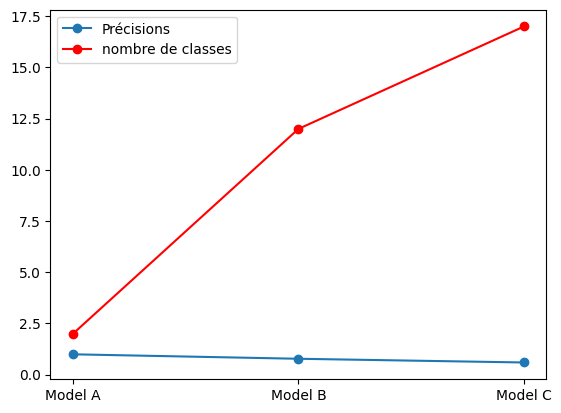

In [26]:
models = ['Model A', 'Model B', 'Model C']
accuracies = [Model_A.getAccuracy(), Model_B.getAccuracy(), Model_C.getAccuracy()]
classNumbers = [Model_A.CLASS_NUMBER, Model_B.CLASS_NUMBER, Model_C.CLASS_NUMBER]

fig, ax = plt.subplots()
ax.plot(models, accuracies, 'o-', label='Précisions')
ax.plot(models, classNumbers, 'o-r', label='nombre de classes')
ax.legend()

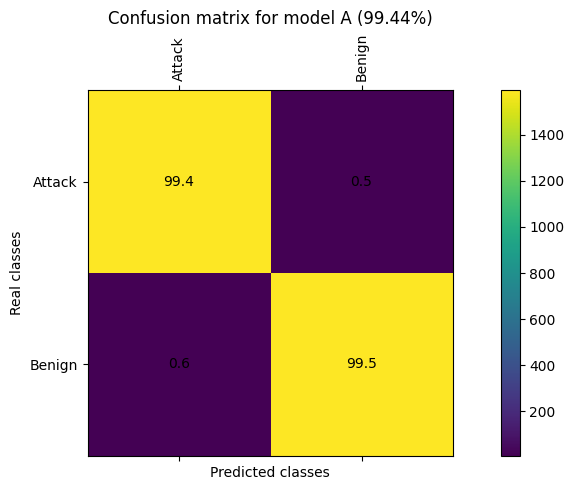

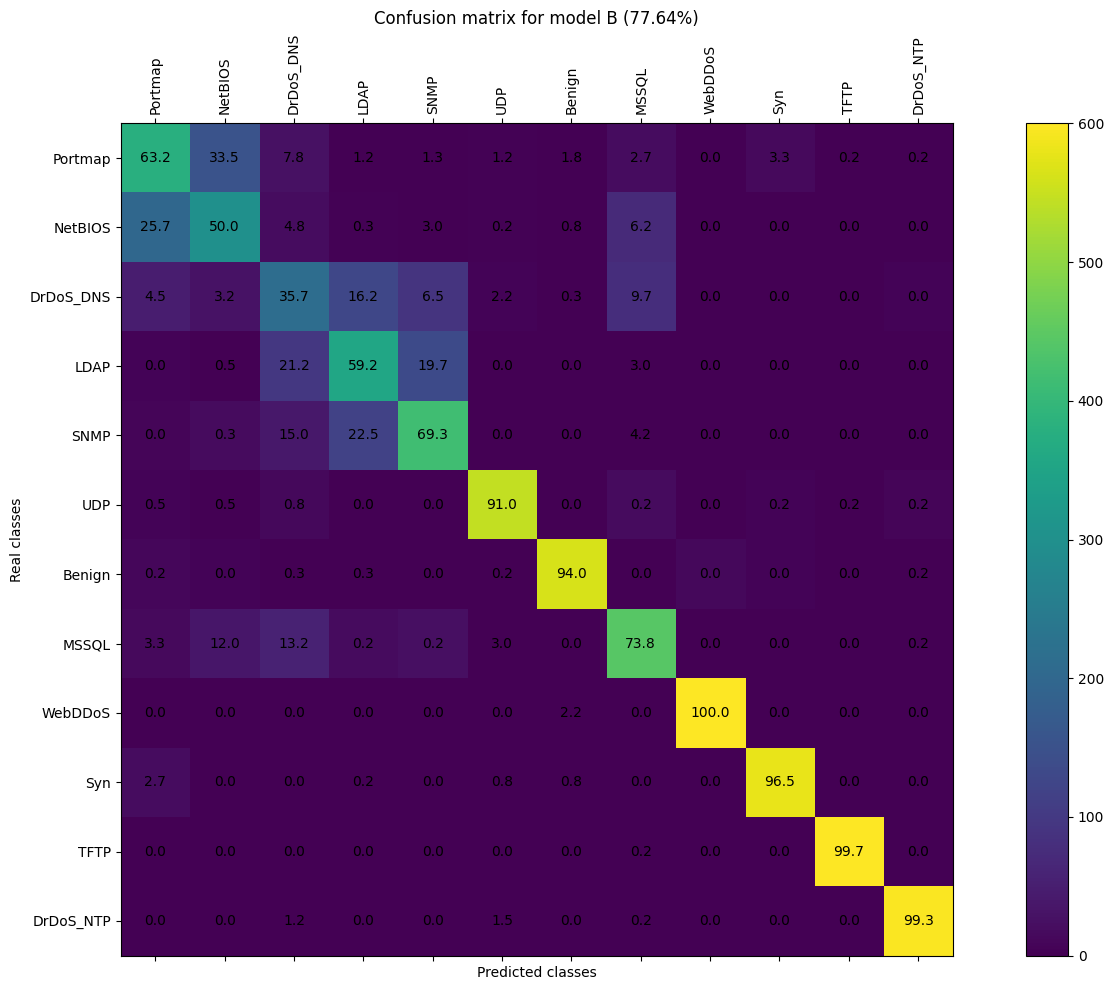

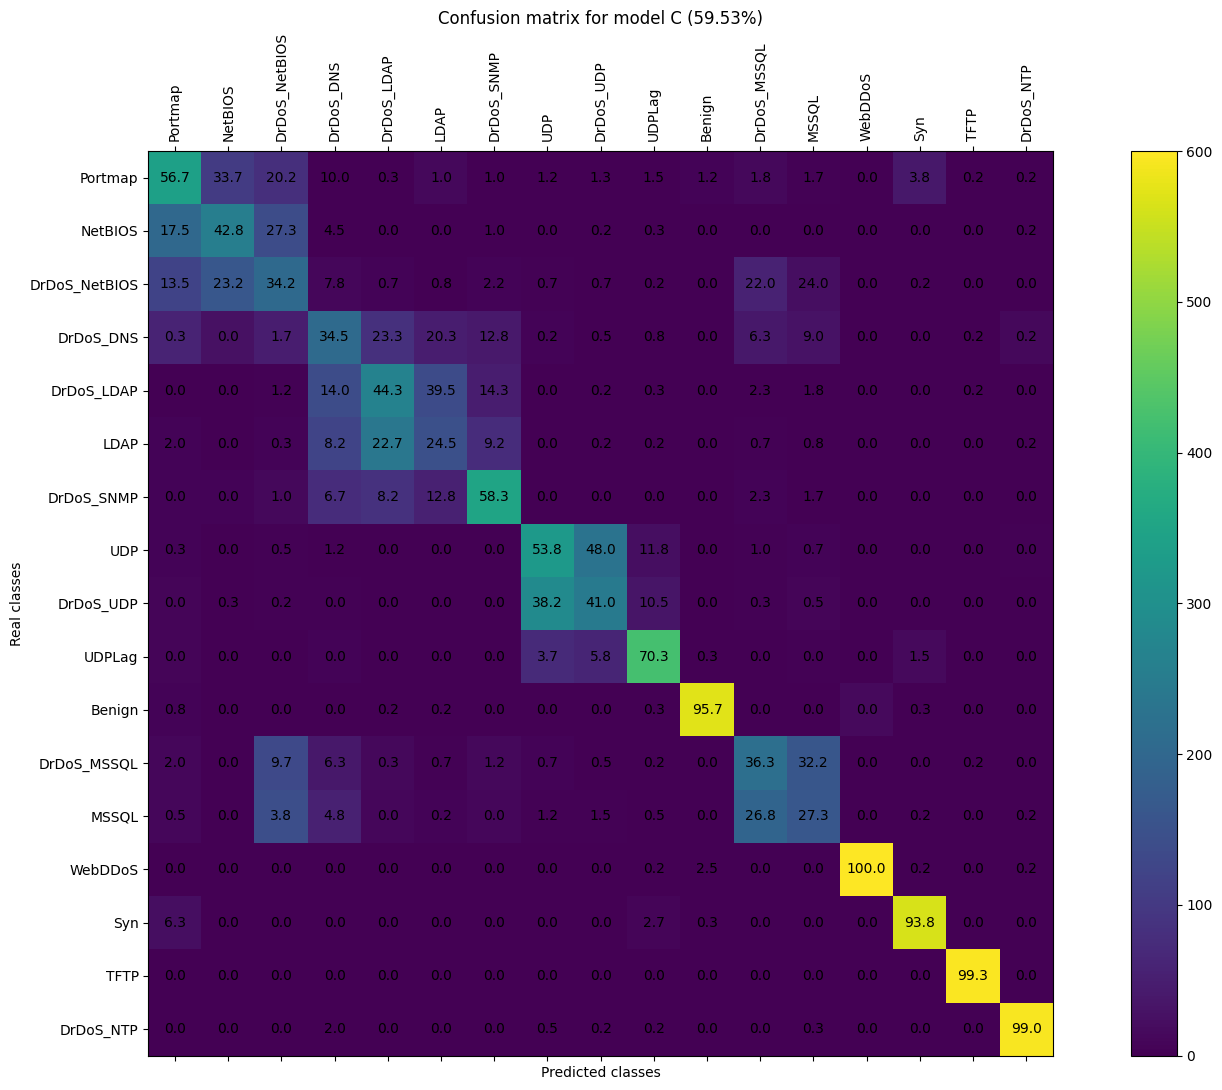

In [27]:
Model_A.displayConfusionMatrix(class_names=['Attack', 'Benign'], figsize=(10,5), max=1600, title='Confusion matrix for model A ({}%)'.format(round(Model_A.getAccuracy()*100, 2)))
Model_B.displayConfusionMatrix(class_names=['Portmap', 'NetBIOS', 'DrDoS_DNS', 'LDAP', 'SNMP', 'UDP', 'Benign', 'MSSQL', 'WebDDoS', 'Syn', 'TFTP', 'DrDoS_NTP'], figsize=(15,10), max=600, title='Confusion matrix for model B ({}%)'.format(round(Model_B.getAccuracy()*100, 2)))
Model_C.displayConfusionMatrix(class_names=['Portmap', 'NetBIOS', 'DrDoS_NetBIOS', 'DrDoS_DNS', 'DrDoS_LDAP', 'LDAP', 'DrDoS_SNMP', 'UDP', 'DrDoS_UDP', 'UDPLag', 'Benign', 'DrDoS_MSSQL', 'MSSQL', 'WebDDoS', 'Syn', 'TFTP', 'DrDoS_NTP'], figsize=(16,11), max=600, title='Confusion matrix for model C ({}%)'.format(round(Model_C.getAccuracy()*100, 2)))

In [28]:
# Model_A.displayEvolution()
# Model_B.displayEvolution()
# Model_C.displayEvolution()

In [29]:
# exporting the confusion matrices
airs_models = [Model_A, Model_B, Model_C]
airs_models_names = ['Model_A', 'Model_B', 'Model_C']
airs_models_labels = [['Attack', 'Benign'],
                      ['Portmap', 'NetBIOS', 'DrDoS_DNS', 'LDAP', 'SNMP', 'UDP', 'Benign', 'MSSQL', 'WebDDoS', 'Syn', 'TFTP', 'DrDoS_NTP'],
                      ['Portmap', 'NetBIOS', 'DrDoS_NetBIOS', 'DrDoS_DNS', 'DrDoS_LDAP', 'LDAP', 'DrDoS_SNMP', 'UDP', 'DrDoS_UDP', 'UDPLag', 'Benign', 'DrDoS_MSSQL', 'MSSQL', 'WebDDoS', 'Syn', 'TFTP', 'DrDoS_NTP']]
for model, model_name, model_labels in zip(airs_models, airs_models_names, airs_models_labels):
    y_pred = model.pred_values
    y_true = model.real_values
    
    confMat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.matshow(confMat)  # You can change the colormap
    # plt.colorbar(cax)

    # Annotate the cells with the counts
    for (i, j), val in np.ndenumerate(confMat):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')
    ax.set_xticks(np.arange(len(model_labels)))
    ax.set_yticks(np.arange(len(model_labels)))
    ax.set_xticklabels(model_labels, rotation=90)
    ax.set_yticklabels(model_labels)
    plt.title(f'Matrice de confusion {model.__class__.__name__} ({round(model.getAccuracy() * 100, 2)}%)')
    plt.xlabel('Prédictions')
    plt.ylabel('classes réelles')
    plt.tight_layout()
    plt.savefig(f'.\\figures\\confusion_matrix_AIRS_{model_name}.png')
    plt.close(fig)

# Artificial Neural Network

## Hybdrid model

In [30]:
# getting the new dataset from MC pool + train test split
mcA_x_raw, mcA_y_raw = Model_A.getMcPOOLasDataset()
mcB_x_raw, mcB_y_raw = Model_B.getMcPOOLasDataset()
mcC_x_raw, mcC_y_raw = Model_C.getMcPOOLasDataset()

smote = SMOTE()
mcA_x, mcA_y = smote.fit_resample(mcA_x_raw, mcA_y_raw)
mcB_x, mcB_y = smote.fit_resample(mcB_x_raw, mcB_y_raw)
mcC_x, mcC_y = smote.fit_resample(mcC_x_raw, mcC_y_raw)

# mcA_x, mcA_y = mcA_x_raw, mcA_y_raw
# mcB_x, mcB_y = mcB_x_raw, mcB_y_raw
# mcC_x, mcC_y = mcC_x_raw, mcC_y_raw

# x_train_A, x_test_A, y_train_A, y_test_A = train_test_split(mcA_x, mcA_y, test_size=0.2, random_state=10)
# x_train_B, x_test_B, y_train_B, y_test_B = train_test_split(mcB_x, mcB_y, test_size=0.2, random_state=10)
# x_train_C, x_test_C, y_train_C, y_test_C = train_test_split(mcC_x, mcC_y, test_size=0.2, random_state=10)

# print('A --- train : {}  - test : {}'.format(len(x_train_A), len(x_test_A)))
# print('B --- train : {}  - test : {}'.format(len(x_train_B), len(x_test_B)))
# print('C --- train : {}  - test : {}'.format(len(x_train_C), len(x_test_C)))

# test_dataset_A = dataset_A.groupby('Label').sample(n=100, random_state=10)
# test_dataset_B = dataset_B.groupby('Label').sample(n=100, random_state=10)
# test_dataset_C = dataset_C.groupby('Label').sample(n=100, random_state=10)
# y_test_A = test_dataset_A['Label'].to_numpy()
# x_test_A = test_dataset_A.drop(columns='Label').to_numpy()
# y_test_B = test_dataset_B['Label'].to_numpy()
# x_test_B = test_dataset_B.drop(columns='Label').to_numpy()
# y_test_C = test_dataset_C['Label'].to_numpy()
# x_test_C = test_dataset_C.drop(columns='Label').to_numpy()

test_A_y = testset_A[: , -1]
test_A_x = testset_A[: , :-1]
test_B_y = testset_B[: , -1]
test_B_x = testset_B[: , :-1]
test_C_y = testset_C[: , -1]
test_C_x = testset_C[: , :-1]

print('A --- train : {}  - test : {}'.format(len(mcA_x), len(test_A_x)))
print('B --- train : {}  - test : {}'.format(len(mcB_x), len(test_B_x)))
print('C --- train : {}  - test : {}'.format(len(mcC_x), len(test_C_x)))


A --- train : 5864  - test : 3200
B --- train : 17556  - test : 7200
C --- train : 23919  - test : 10200


In [31]:
# passing the dataset through affinity maturation
# memory cell pool mcA_x_raw, mcA_y_raw

# def affinity(vec1, vect2):

def mutate(vectorToMutate, mutationRate):
    mutated = False
    while mutated == False:
        mutated_vect = []
        for idx, feature in enumerate(vectorToMutate):
            if random.random() <= mutationRate:
                stddev = 0.02
                mutated_vect.append(random.gauss(feature, stddev))
                # mutated_vect.append(random.uniform(MINs[idx], MAXs[idx]))
                mutated = True
            else:
                mutated_vect.append(feature) 
    return np.array(mutated_vect)

def affinity_maturation(x_test, y_test, model):
    new_x_test = []
    bzzt = 0

    for antigene, _class in zip(x_test, y_test):
        bzzt += 1
        # print('===================   {}   ====================='.format(bzzt))
        # print(bzzt)
        # finding the best match from mc pool
        bestAffinity = 0.0
        for mcCell in model.MC_POOL.get(_class):
            aff = AIRS.affinity(antigene, mcCell.vector)
            if aff > bestAffinity:
                bestAffinity = aff
                bestMcMatch = antigene
        
        # clonal expansion
        ARB_pool = []
        # put the best match in arp pool
        ARB_pool.append((bestMcMatch, bestAffinity))

        iter = 0
        maxClones = 50
        keepNumber = 10
        while True:
            iter += 1
            # print('-----------   {} -----------'.format(iter))
            # print(iter)
            # generate mutated clones from the best ARB
            numClones = len(ARB_pool)
            bestARB_vector = max(ARB_pool, key=lambda x:x[1])[0]
            while numClones < maxClones:
                numClones += 1
                newVector = mutate(bestARB_vector, 0.04)
                newStim = AIRS.affinity(antigene, newVector)
                ARB_pool.append((newVector, newStim))
            # print('max clones created')
            
            avgStim = sum(x[1] for x in ARB_pool) / len(ARB_pool)

            # delete worst ARBs
            ARB_pool.sort(key=lambda x:-x[1])
            # print(ARB_pool[0][1])
            # print(ARB_pool[-1][1])
            # print('__________________________')
            for _ in range(maxClones-keepNumber) : ARB_pool.pop()

            # repeat this until avgStim is high or max iter reached
            # print('{} (sum) / {} (len arb) = {} > 0.85'.format(sum(x[1] for x in ARB_pool), len(ARB_pool), sum(x[1] for x in ARB_pool) / len(ARB_pool)))
            if avgStim > 0.98 or iter > 100:
                break
        
        # print('{} (best affinity) > {} (best ARB)'.format(bestAffinity, ARB_pool[0][1]))
        # compare best ARB (candidate) with bestMcMatch in affinity with antigene
        # add the best one to the new trainset
        if bestAffinity > ARB_pool[0][1]:
            new_x_test.append(bestMcMatch)
            # print('mc best match    OOOOOOOOOOOOOOOOOOOOOOO')
        else:
            new_x_test.append(ARB_pool[0][0])
            # print(ARB_pool[0][1])
            # print('the best arb    ||||||||||||||||||||||||')

    return np.array(new_x_test)

# x_test_A_matured = affinity_maturation(test_A_x, test_A_y, Model_A)
# print('x test A matured')
# x_test_B_matured = affinity_maturation(test_B_x, test_B_y, Model_B)
# print('x test B matured')
# x_test_C_matured = affinity_maturation(test_C_x, test_C_y, Model_C)
# print('x test C matured')


In [32]:
# instad of maturing, transform each test sample into its closest sample from mcpool

def toMCPool(x_test, y_test, model):
    new_x_test = []
    for antigene, _class in zip(x_test, y_test):
        # finding the mc cell with highest affinity with antigene
        best_aff = 0.0
        for cell in model.MC_POOL.get(_class):
            aff = model.affinity(antigene, cell.vector)
            if aff > best_aff:
                best_aff = aff
                best_aff_vector = cell.vector
        
        # adding the best aff vector to the new xtest
        new_x_test.append(best_aff_vector)
    return np.array(new_x_test)

x_test_A_matured = toMCPool(test_A_x, test_A_y, Model_A)
print('x test A matured')
x_test_B_matured = toMCPool(test_B_x, test_B_y, Model_B)
print('x test B matured')
x_test_C_matured = toMCPool(test_C_x, test_C_y, Model_C)
print('x test C matured')

x test A matured
x test B matured
x test C matured


In [33]:
from sklearn.neural_network import MLPClassifier



# MLP_classifier = MLPClassifier(hidden_layer_sizes=(250,), activation='relu', solver='adam', max_iter=2000, random_state=10)
HybridModel = MLPClassifier(
    hidden_layer_sizes = (100,),
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=10
    )

HybridModel.fit(mcA_x, mcA_y)
y_pred_A = HybridModel.predict(x_test_A_matured)
with open('.\\saved_models\\Hybrid_MLP_A.pkl', 'wb') as file:
    pickle.dump(HybridModel, file)
print('model A done')

HybridModel.fit(mcB_x, mcB_y)
y_pred_B = HybridModel.predict(x_test_B_matured)
with open('.\\saved_models\\Hybrid_MLP_B.pkl', 'wb') as file:
    pickle.dump(HybridModel, file)
print('model B done')

HybridModel.fit(mcC_x, mcC_y)
y_pred_C = HybridModel.predict(x_test_C_matured)
with open('.\\saved_models\\Hybrid_MLP_C.pkl', 'wb') as file:
    pickle.dump(HybridModel, file)
print('model C done')


model A done
model B done
model C done


In [34]:
report_A = classification_report(test_A_y, y_pred_A, output_dict=True)
report_B = classification_report(test_B_y, y_pred_B, output_dict=True)
report_C = classification_report(test_C_y, y_pred_C, output_dict=True)

print(report_A['accuracy'])
print(report_B['accuracy'])
print(report_C['accuracy'])

# 0.9990625
# 0.7577777777777778
# 0.6187254901960785

# best results   (smote, mutated_2, code change)
# 0.99875
# 0.8043055555555556
# 0.6553921568627451

0.99875
0.7833333333333333
0.639313725490196


In [35]:
# exporting confusion matrices
for y_pred, y_true, model_name, model_labels, model_accuracy in zip([y_pred_A, y_pred_B, y_pred_C], [test_A_y, test_B_y, test_C_y], ['Model_A', 'Model_B', 'Model_C'], airs_models_labels, [report_A['accuracy'], report_B['accuracy'], report_C['accuracy']]):
    confMat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.matshow(confMat)
    # plt.colorbar(cax)

    for (i, j), val in np.ndenumerate(confMat):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')
    ax.set_xticks(np.arange(len(model_labels)))
    ax.set_yticks(np.arange(len(model_labels)))
    ax.set_xticklabels(model_labels, rotation=90)
    ax.set_yticklabels(model_labels)
    plt.title(f'Matrice de confusion Hybrid {model_name} ({round(model_accuracy * 100, 2)}%)')
    plt.xlabel('Prédictions')
    plt.ylabel('classes réelles')
    plt.tight_layout()
    plt.savefig(f'.\\figures\\confusion_matrix_HYB_{model_name}.png')
    plt.close(fig)

In [36]:
# results with mca, mcb, mcc WITHOUT SMOTE  (results to reach)
# 0.99609375
# 0.9143988124690747
# 0.8366666666666667

## MLP Alone

In [37]:
x_train_A_o, x_test_A_o, y_train_A_o, y_test_A_o = train_test_split(dataset_A.iloc[:,:-1], dataset_A.iloc[:,-1], test_size=0.2, random_state=10)
x_train_B_o, x_test_B_o, y_train_B_o, y_test_B_o = train_test_split(dataset_B.iloc[:,:-1], dataset_B.iloc[:,-1], test_size=0.2, random_state=10)
x_train_C_o, x_test_C_o, y_train_C_o, y_test_C_o = train_test_split(dataset_C.iloc[:,:-1], dataset_C.iloc[:,-1], test_size=0.2, random_state=10)

MLP_classifier = MLPClassifier(
    hidden_layer_sizes = (100,),
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=10
    )

MLP_classifier.fit(x_train_A_o, y_train_A_o)
y_pred_A_o = MLP_classifier.predict(x_test_A_o)
with open('.\\saved_models\\MLP_A.pkl', 'wb') as file:
    pickle.dump(MLP_classifier, file)

MLP_classifier.fit(x_train_B_o, y_train_B_o)
y_pred_B_o = MLP_classifier.predict(x_test_B_o)
with open('.\\saved_models\\MLP_B.pkl', 'wb') as file:
    pickle.dump(MLP_classifier, file)

MLP_classifier.fit(x_train_C_o, y_train_C_o)
y_pred_C_o = MLP_classifier.predict(x_test_C_o)
with open('.\\saved_models\\MLP_C.pkl', 'wb') as file:
    pickle.dump(MLP_classifier, file)

    

report_A_o = classification_report(y_test_A_o, y_pred_A_o, output_dict=True)
report_B_o = classification_report(y_test_B_o, y_pred_B_o, output_dict=True)
report_C_o = classification_report(y_test_C_o, y_pred_C_o, output_dict=True)

In [38]:
# exporting confusion matrices
for y_pred, y_true, model_name, model_labels, model_accuracy in zip([y_pred_A_o, y_pred_B_o, y_pred_C_o], [y_test_A_o, y_test_B_o, y_test_C_o], ['Model_A', 'Model_B', 'Model_C'], airs_models_labels, [report_A_o['accuracy'], report_B_o['accuracy'], report_C_o['accuracy']]):
    # confMat = confusion_matrix(y_true, y_pred)
    confMat = confusion_matrix(y_pred, y_true)
    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.matshow(confMat)
    # plt.colorbar(cax)

    for (i, j), val in np.ndenumerate(confMat):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')
    ax.set_xticks(np.arange(len(model_labels)))
    ax.set_yticks(np.arange(len(model_labels)))
    ax.set_xticklabels(model_labels, rotation=90)
    ax.set_yticklabels(model_labels)
    plt.title(f'Matrice de confusion MLP {model_name} ({round(model_accuracy * 100, 2)}%)')
    plt.xlabel('Prédictions')
    plt.ylabel('classes réelles')
    plt.tight_layout()
    plt.savefig(f'.\\figures\\confusion_matrix_SECOND_{model_name}.png')
    plt.close(fig)

# Comparaison AIRS vs Hybrid (AIRS + MLP)

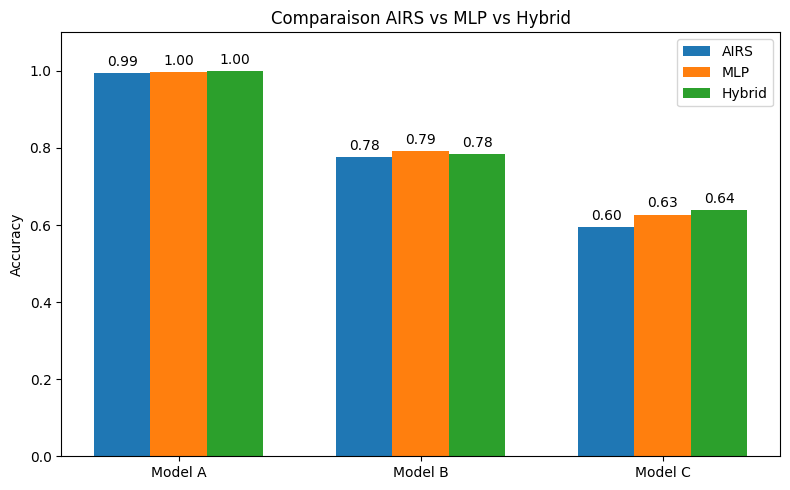

In [39]:
old_accuracies = [Model_A.getAccuracy(), Model_B.getAccuracy(), Model_C.getAccuracy()]
original_accuracies = [report_A_o['accuracy'], report_B_o['accuracy'], report_C_o['accuracy']]
new_accuracies = [report_A['accuracy'], report_B['accuracy'], report_C['accuracy']]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x - width/3*2, old_accuracies, width/1.5, label='AIRS')
rects2 = ax.bar(x + width/2*0, original_accuracies, width/1.5, label='MLP')
rects3 = ax.bar(x + width/3*2, new_accuracies, width/1.5, label='Hybrid')

# Add labels
ax.set_ylabel('Accuracy')
ax.set_title('Comparaison AIRS vs MLP vs Hybrid')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.1)
ax.legend()

# Add accuracy values on top of bars
ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')

plt.tight_layout()
plt.show()


## Hybdridation with Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

hybrid_rf = RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=None,
    random_state=10,
    verbose = False
    )

hybrid_rf.fit(mcA_x, mcA_y)
y_pred_A = hybrid_rf.predict(x_test_A_matured)
with open('.\\saved_models\\Hybrid_RF_A.pkl', 'wb') as file:
    pickle.dump(hybrid_rf, file)
print('model A done')

hybrid_rf.fit(mcB_x, mcB_y)
y_pred_B = hybrid_rf.predict(x_test_B_matured)
with open('.\\saved_models\\Hybrid_RF_B.pkl', 'wb') as file:
    pickle.dump(hybrid_rf, file)
print('model B done')

hybrid_rf.fit(mcC_x, mcC_y)
y_pred_C = hybrid_rf.predict(x_test_C_matured)
with open('.\\saved_models\\Hybrid_RF_C.pkl', 'wb') as file:
    pickle.dump(hybrid_rf, file)
print('model C done')

report_A = classification_report(test_A_y, y_pred_A, output_dict=True)
report_B = classification_report(test_B_y, y_pred_B, output_dict=True)
report_C = classification_report(test_C_y, y_pred_C, output_dict=True)



rfModel = RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=None,
    random_state=10,
    verbose = False
    )

x_train_A_o, x_test_A_o, y_train_A_o, y_test_A_o = train_test_split(dataset_A.iloc[:,:-1], dataset_A.iloc[:,-1], test_size=0.2, random_state=10)
x_train_B_o, x_test_B_o, y_train_B_o, y_test_B_o = train_test_split(dataset_B.iloc[:,:-1], dataset_B.iloc[:,-1], test_size=0.2, random_state=10)
x_train_C_o, x_test_C_o, y_train_C_o, y_test_C_o = train_test_split(dataset_C.iloc[:,:-1], dataset_C.iloc[:,-1], test_size=0.2, random_state=10)

rfModel.fit(x_train_A_o, y_train_A_o)
y_pred_A_o = rfModel.predict(x_test_A_o)
with open('.\\saved_models\\RF_A.pkl', 'wb') as file:
    pickle.dump(rfModel, file)
print('model A done')

rfModel.fit(x_train_B_o, y_train_B_o)
y_pred_B_o = rfModel.predict(x_test_B_o)
with open('.\\saved_models\\RF_B.pkl', 'wb') as file:
    pickle.dump(rfModel, file)
print('model B done')

rfModel.fit(x_train_C_o, y_train_C_o)
y_pred_C_o = rfModel.predict(x_test_C_o)
with open('.\\saved_models\\RF_C.pkl', 'wb') as file:
    pickle.dump(rfModel, file)
print('model C done')

report_A_o = classification_report(y_test_A_o, y_pred_A_o, output_dict=True)
report_B_o = classification_report(y_test_B_o, y_pred_B_o, output_dict=True)
report_C_o = classification_report(y_test_C_o, y_pred_C_o, output_dict=True)

model A done
model B done
model C done
model A done
model B done
model C done


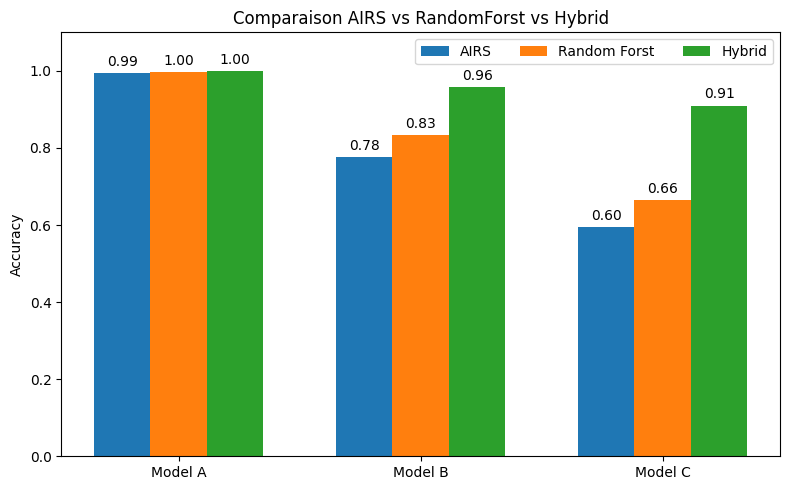

In [41]:
old_accuracies = [Model_A.getAccuracy(), Model_B.getAccuracy(), Model_C.getAccuracy()]
new_accuracies = [report_A['accuracy'], report_B['accuracy'], report_C['accuracy']]
original_accuracies = [report_A_o['accuracy'], report_B_o['accuracy'], report_C_o['accuracy']]

x = np.arange(len(models))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x - width/3*2, old_accuracies, width/1.5, label='AIRS')
rects2 = ax.bar(x + width/2*0, original_accuracies, width/1.5, label='Random Forst')
rects3 = ax.bar(x + width/3*2, new_accuracies, width/1.5, label='Hybrid')

# Add labels
ax.set_ylabel('Accuracy')
ax.set_title('Comparaison AIRS vs RandomForst vs Hybrid')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.1)
ax.legend(ncol=3)

# Add accuracy values on top of bars
ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')

plt.tight_layout()
plt.show()


In [42]:
# exporting confusion matrices
for y_pred, y_true, model_name, model_labels, model_accuracy in zip([y_pred_A, y_pred_B, y_pred_C], [test_A_y, test_B_y, test_C_y], ['Model_A', 'Model_B', 'Model_C'], airs_models_labels, [report_A['accuracy'], report_B['accuracy'], report_C['accuracy']]):
    confMat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.matshow(confMat)
    # plt.colorbar(cax)

    for (i, j), val in np.ndenumerate(confMat):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')
    ax.set_xticks(np.arange(len(model_labels)))
    ax.set_yticks(np.arange(len(model_labels)))
    ax.set_xticklabels(model_labels, rotation=90)
    ax.set_yticklabels(model_labels)
    plt.title(f'Matrice de confusion Hybrid {model_name} ({round(model_accuracy * 100, 2)}%)')
    plt.xlabel('Prédictions')
    plt.ylabel('classes réelles')
    plt.tight_layout()
    plt.savefig(f'.\\figures\\confusion_matrix_HYB_{model_name}.png')
    plt.close(fig)

In [ ]:
# exporting comparaison between all metrics
report_airs_A = Model_A.getReport()
report_airs_B = Model_B.getReport()
report_airs_C = Model_C.getReport()


metrics = ['accuracy', 'precision', 'recall', 'f1-score']
models = ['Model A', 'Model B', 'Model C']
for metric in metrics:
    if metric == 'accuracy':
        AIRS_metrics = [report_airs_A['accuracy'], report_airs_B['accuracy'], report_airs_C['accuracy']]
        model_metrics = [report_A_o['accuracy'], report_B_o['accuracy'], report_C_o['accuracy']]
        Hybrid_metrics = [report_A['accuracy'], report_B['accuracy'], report_C['accuracy']]
    else:
        AIRS_metrics = [report_airs_A['weighted avg'][metric], report_airs_B['weighted avg'][metric], report_airs_C['weighted avg'][metric]]
        model_metrics = [report_A_o['weighted avg'][metric], report_B_o['weighted avg'][metric], report_C_o['weighted avg'][metric]]
        Hybrid_metrics = [report_A['weighted avg'][metric], report_B['weighted avg'][metric], report_C['weighted avg'][metric]]
    
    x = np.arange(len(models))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 5))

    rects1 = ax.bar(x - width/3*2, AIRS_metrics, width/1.5, label='AIRS')
    rects2 = ax.bar(x + width/2*0, model_metrics, width/1.5, label='Random Forst')
    rects3 = ax.bar(x + width/3*2, Hybrid_metrics, width/1.5, label='Hybrid')

    # Add labels
    ax.set_ylabel(metric)
    ax.set_title('Comparaison AIRS vs MLP vs Hybrid')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylim(0, 1.1)
    ax.legend(ncol=3)

    # Add accuracy values on top of bars
    ax.bar_label(rects1, padding=3, fmt='%.2f')
    ax.bar_label(rects2, padding=3, fmt='%.2f')
    ax.bar_label(rects3, padding=3, fmt='%.2f')

    plt.tight_layout()
    plt.savefig(f'.\\figures\\comparaison_{metric}.png')
    plt.close()


In [44]:
# exporting airs models
with open('.\\saved_models\\AIRS_A.pkl', 'wb') as file:
    pickle.dump(Model_A, file)
with open('.\\saved_models\\AIRS_B.pkl', 'wb') as file:
    pickle.dump(Model_B, file)
with open('.\\saved_models\\AIRS_C.pkl', 'wb') as file:
    pickle.dump(Model_C, file)

In [45]:
for _class in report_B.keys():
    if _class == 'accuracy' or _class ==  'macro avg' or _class ==  'weighted avg': continue
    for metric in metrics:
        print(_class)
        a = report_B[_class][metric]

0.0


KeyError: 'accuracy'

In [46]:
# exporting individual classes metrics

metrics = ['precision', 'recall', 'f1-score']
reports = [report_A, report_B, report_C]
metricsA = {x:[] for x in metrics}
metricsB = {x:[] for x in metrics}
metricsC = {x:[] for x in metrics}
A_classes = ['Attack', 'Benign']
B_classes = ['Portmap', 'NetBIOS', 'DrDoS_DNS', 'LDAP', 'DrDoS_SNMP', 'UDP', 'Benign', 'MSSQL', 'WebDDoS', 'Syn', 'TFTP', 'DrDoS_NTP']
C_classes = ['Portmap', 'NetBIOS', 'DrDoS_NetBIOS', 'DrDoS_DNS', 'DrDoS_LDAP', 'LDAP', 'DrDoS_SNMP', 'UDP', 'DrDoS_UDP', 'UDPLag', 'Benign', 'DrDoS_MSSQL', 'MSSQL', 'WebDDoS', 'Syn', 'TFTP', 'DrDoS_NTP']


for _class in report_A.keys():
    if _class == 'accuracy' or _class ==  'macro avg' or _class ==  'weighted avg': continue
    for metric in metrics:
        metricsA[metric].append(report_A[_class][metric])
for _class in report_B.keys():
    if _class == 'accuracy' or _class ==  'macro avg' or _class ==  'weighted avg': continue
    for metric in metrics:
        metricsB[metric].append(report_B[_class][metric])
for _class in report_C.keys():
    if _class == 'accuracy' or _class ==  'macro avg' or _class ==  'weighted avg': continue
    for metric in metrics:
        metricsC[metric].append(report_C[_class][metric])


In [47]:
# plotting metrics of A
for metric in metrics:
    fig, ax = plt.subplots()
    ax.bar(A_classes, metricsA[metric])
    ax.set_xticks(range(len(A_classes)))
    ax.set_xticklabels(A_classes, rotation=90)
    ax.set_title(f'{metric} des classes Mödel_A')
    ax.set_ylim(0,1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'.\\figures\\{metric}_Model_A.png')
    plt.close()

# plotting metrics of B
for metric in metrics:
    fig, ax = plt.subplots()
    ax.bar(B_classes, metricsB[metric])
    ax.set_xticks(range(len(B_classes)))
    ax.set_xticklabels(B_classes, rotation=90)
    ax.set_title(f'{metric} des classes Model_B')
    ax.set_ylim(0,1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'.\\figures\\{metric}_Model_B.png')
    plt.close()

# plotting metrics of C
for metric in metrics:
    fig, ax = plt.subplots()
    ax.bar(C_classes, metricsC[metric])
    ax.set_xticks(range(len(C_classes)))
    ax.set_xticklabels(C_classes, rotation=90)
    ax.set_title(f'{metric} des classes Model_C')
    ax.set_ylim(0,1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'.\\figures\\{metric}_Model_C.png')
    plt.close()